In [152]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

## 1. Constants:

In [53]:
L = 1000 # fiber length, m
Ladc = 1 # sampling frequency of receiver, m
alpha = 0.0410517 * 1e-3 # attenuation, 1/m
c = 300000000 # light speed, m/s
n0 = 1.5      # refractive index
lamda = 1550e-9 # wavelength, m
kv = 2*np.pi/lamda # wavenumber, 1/m  
w0 = kv * c # carrier frequency, Hz
n_metre = 2 # number rayleigh centres (RC) at 1 m

## 2. Graphical scalar model of fiber with random distrbution RC along Z-axis:
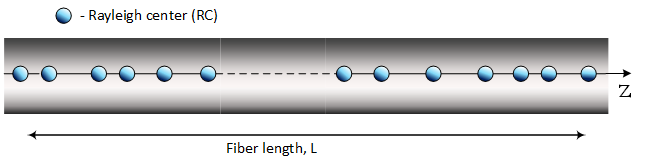

In [54]:
np.random.seed(1) # fixing random RC distribution
z_sc = np.sort(np.random.rand(int(n_metre*L)))*L # RC's coordinates along fiber

## 3 Backscattering signal graphical model:
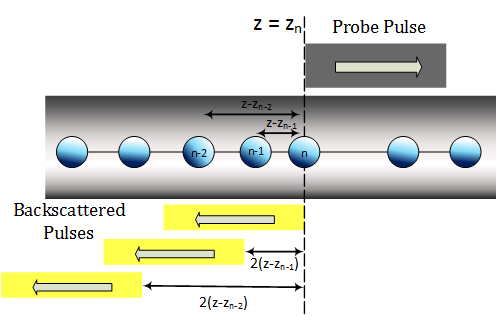

Sum of backscattered pulses at every RC:

$$A(z) = \sum_{n}^N H(2z-2z_n)\cdot e^{2ikz_n}$$  

In [55]:
Ndots = int(L / Ladc) 
A = np.zeros(Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)
time_back = 2 * L * n0 / c  # duration of backscattering signal, s
T = np.linspace(0, time_back, Ndots) # time-window of backscattered signal, s
Distance = T*c/n0/2 # spatial-window of backscattered signal, s
tau=200e-9
Timp = T[T <= tau]                        # time-window of probe pulse, s
H = np.heaviside(tau/2 - np.abs(Timp-tau/2),1) # probe pulse  

## 3. Simulation OTDR waterfall

### 3.1. Linear srain fiber over time
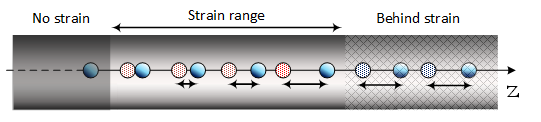

Text(775.0, 0.9, 'Behind strain')

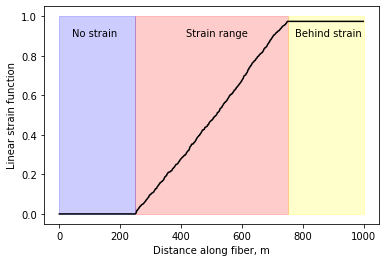

In [100]:
z_strain=L/4
range_strain=L/2
strain_func = np.cumsum(np.heaviside(range_strain/2 - np.abs(z_sc-z_strain-range_strain/2),1))/range_strain/n_metre
plt.plot(z_sc, strain_func, c='k')
plt.xlabel('Distance along fiber, m')
plt.ylabel('Linear strain function')

y=np.linspace(0,1,10)
x1=np.ones(10)*z_strain
x2=np.ones(10)*z_strain+range_strain
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='r', alpha=0.2)
plt.annotate('Strain range', xy=(z_strain+range_strain/3, 0.9))

x1=np.zeros(10)
x2=np.ones(10)*z_strain
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='b', alpha=0.2)
plt.annotate('No strain', xy=(z_strain/6, 0.9))

x1=np.ones(10)*z_strain+range_strain
x2=np.ones(10)*L
plt.fill_betweenx(y=y, x1=x1, x2=x2, color='yellow', alpha=0.2)
plt.annotate('Behind strain', xy=(z_strain+range_strain*1.05, 0.9))

### 3.2. Calculation complex amplitudes of OTDR-traces with linear srain fiber over time

In [101]:
def trace_strain(z_sc, T, strain_func, strain):
    dz = 0
    A = np.zeros(Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)
    dz_sc = z_sc + strain_func * strain * T
    for z_n in dz_sc:
                
        pulse_back = H * np.exp(2j * (kv * z_n) -  2 * z_n * alpha) # backscattered pulse at receiver (z=0)
        Zn = int(z_n / L * (Ndots) - len(Timp)) # it z-coordinate index in spatial-window "Distance" OTDR-trace

        if Zn < 0: 
            A[0:Zn+len(Timp)] += pulse_back[:Zn+len(Timp)]

        elif Zn >= 0: # in case when part pulse behind of spatial-window
            A[Zn:Zn+len(Timp)] += pulse_back[:]

        else: # in case when part pulse beyound of spatial-window
            A[Zn:Ndots] += pulse_back[:Ndots - Zn] 
    return A

In [102]:
fp = 1000 # probing frequency, Hz
Longtime = 1 # time capturing data, s
Time = np.arange(0, Longtime, 1/fp)

z_strain=L/4
range_strain=L/2
strain_func = np.cumsum(np.heaviside(range_strain/2 - np.abs(z_sc-z_strain-range_strain/2),1))/range_strain/n_metre
strain = 1e-3 * range_strain / fp # milistrain per second

Waterfall = np.zeros((len(Time), len(Distance)), dtype=np.complex64)

In [103]:
for i, T in enumerate(Time):
    Waterfall[i,:] = trace_strain(z_sc=z_sc, T=T, strain_func=strain_func, strain=strain)

## 4. Phase vs Intensity

### 4.1. Difference OTDR-traces (intensity)

In [107]:
waterfall_intensity = np.abs(Waterfall)**2
diff_waterfall = waterfall_intensity - waterfall_intensity[0]

Text(0, 0.5, 'Changing intensity, o.e.')

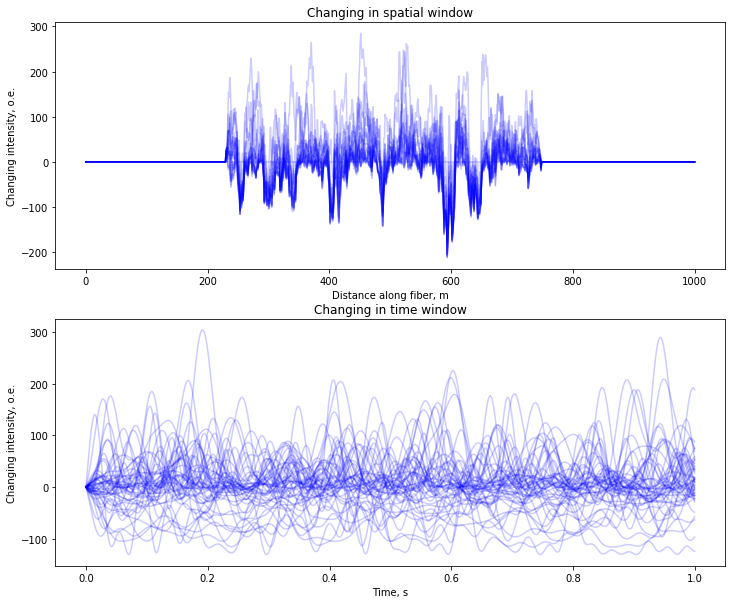

In [108]:
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.title('Changing in spatial window')
plt.plot(Distance, diff_waterfall[::50].T, alpha=0.2, color='b')

plt.xlabel('Distance along fiber, m')
plt.ylabel('Changing intensity, o.e.')

plt.subplot(212)
plt.title('Changing in time window')
plt.plot(Time, diff_waterfall[:,::10][:,(Distance[::10]>z_strain) & (Distance[::10]<z_strain+range_strain)], alpha=0.2, color='b')

plt.xlabel('Time, s')
plt.ylabel('Changing intensity, o.e.')

Text(0.5, 1.0, 'OTDR difference waterfall')

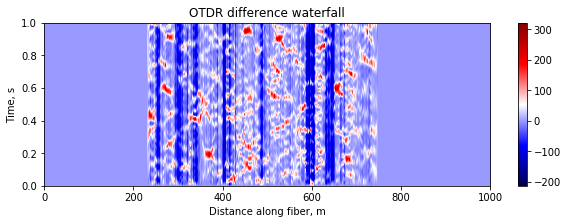

In [109]:
plt.figure(figsize=(10,3))
plt.imshow(diff_waterfall, aspect='auto', origin='bottom', extent=[0, L, 0, Longtime], cmap='seismic')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('OTDR difference waterfall')

# 3d?

### 4.2. Difference Phase OTDR-traces 

  #### 4.2.1. Method of phase extraction from intensity OTDR-traces

#### Pair pulse [method](https://iopscience.iop.org/article/10.1088/1555-6611/aac714) for extraction phase changing between two pulses:

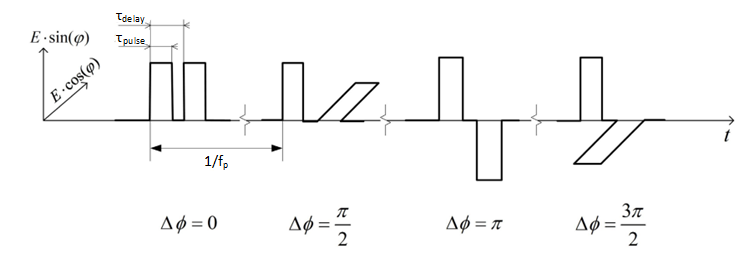

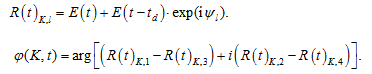

Amplitude of pair pulse: $E(z) = A(z+\tau_{delay} \frac{c}{n}) + A(z)\cdot e^{i\psi_k} $

where $\psi$ changes with period 4 OTDR-traces and values equal to $[0,\frac{\pi}{2}, \pi, \frac{3\pi}{2}]$

Phase change $\varphi (z)$ from 4 OTDR-traces equals to $arg \left[\left(|E_1(z)|^2 - |E_3(z)|^2\right) + i\left(|E_2(z)|^2 - |E_4(z)|^2\right) \right]$ 

\**effective probing frequency is reduced by 4 times*


  #### 4.2.2. Calculation amplitudes of pair pulses

In [110]:
psi = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
tau_delay = 300e-9
gauge_length = tau_delay * c / n0 / 2
index_gl = int(gauge_length /L * Ndots)

In [135]:
E = np.zeros((len(Time), len(Distance)-index_gl), dtype=np.complex64)

E = Waterfall[:,:-index_gl] - Waterfall[:,index_gl:] * np.exp(1j * psi[np.arange(0,len(Time),1) % 4])[:, None]

Text(0.5, 1.0, 'OTDR waterfall pair pulses')

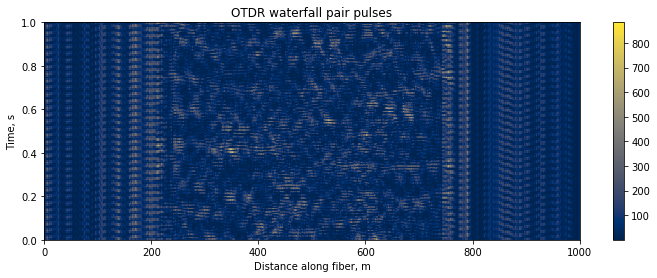

In [136]:
plt.figure(figsize=(12,4))
plt.imshow(np.abs(E)**2, aspect='auto', origin='bottom', extent=[0, L, 0, Longtime], cmap='cividis')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('OTDR waterfall pair pulses')

In [141]:
X1 = (np.abs(E)**2)[0::4,:]
X2 = (np.abs(E)**2)[1::4,:]
X3 = (np.abs(E)**2)[2::4,:]
X4 = (np.abs(E)**2)[3::4,:]

phi = np.unwrap(np.arctan2(X1 - X3, X2 - X4), axis=0)
phi -= phi[0]

Text(0, 0.5, 'Changing intensity, o.e.')

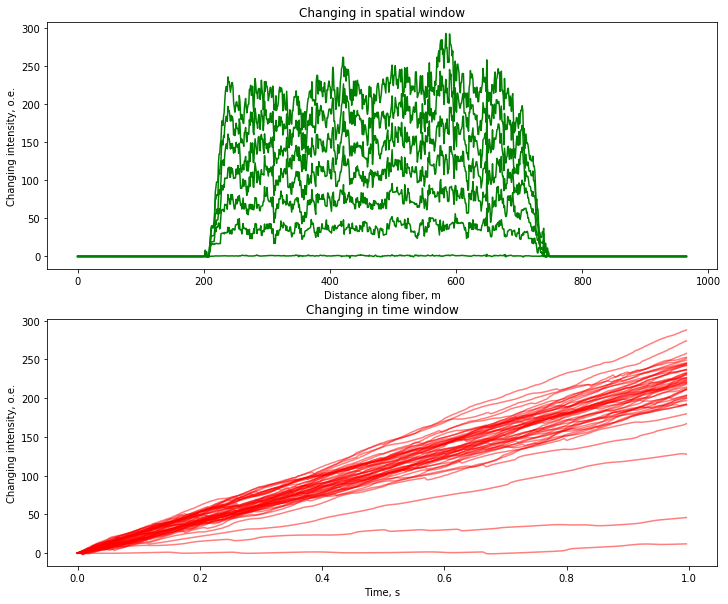

In [226]:
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.title('Changing in spatial window')
plt.plot(Distance[:-index_gl-5], phi[1::40,:-5].T, alpha=1, color='green')

plt.xlabel('Distance along fiber, m')
plt.ylabel('Changing intensity, o.e.')

plt.subplot(212)
plt.title('Changing in time window')
plt.plot(Time[::4], phi[:,::10][:,(Distance[:-index_gl:10]>z_strain) & (Distance[:-index_gl:10]<z_strain+range_strain)],
         alpha=0.5, color='red')

plt.xlabel('Time, s')
plt.ylabel('Changing intensity, o.e.')

Text(0.5, 1.0, 'Phase waterfall')

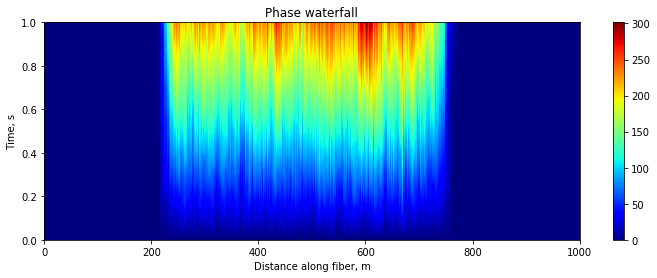

In [150]:
plt.figure(figsize=(12,4))
plt.imshow(phi, aspect='auto', origin='bottom', extent=[0, L, 0, Longtime], cmap='jet', vmin=0)
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('Phase waterfall')

### Phase changes has linear response on fiber strain in comparison intensity 

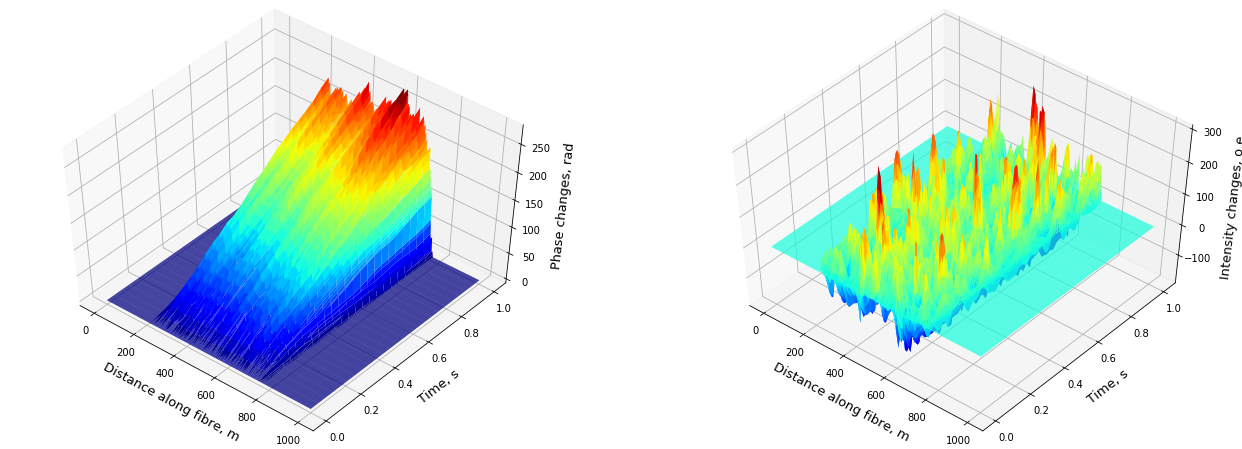

In [229]:
fig = plt.figure(figsize=(22,8))

ax = fig.add_subplot(121, projection='3d')

data3d = phi[::10, :-5:2]
T3d = np.linspace(0, L,len(data3d[0]))
Z3d = np.linspace(0, Longtime, len(data3d))[:,None]

oX = T3d
oY = data3d
oZ = Z3d 

ax.plot_surface(oX, oZ, oY, rstride = 1, cstride = 1, cmap="jet")

ax.set_xlabel('\nDistance along fibre, m',fontsize=13)
ax.set_ylabel('\nTime, s',fontsize=13)
ax.set_zlabel('\nPhase changes, rad',fontsize=13)

ax.view_init(50, -50)


ax = fig.add_subplot(122, projection='3d')

data3d = diff_waterfall[::10, :-5:2]
T3d = np.linspace(0, L,len(data3d[0]))
Z3d = np.linspace(0, Longtime, len(data3d))[:,None]

oX = T3d
oY = data3d
oZ = Z3d 

ax.plot_surface(oX, oZ, oY, rstride = 1, cstride = 1, cmap="jet")

ax.set_xlabel('\nDistance along fibre, m',fontsize=13)
ax.set_ylabel('\nTime, s',fontsize=13)
ax.set_zlabel('\nIntensity changes, o.e.',fontsize=13)

ax.view_init(50, -50)